# PIERS Data Cleaning

This notebook addresses missing data and other issues in the PIERS BOL data. This work is predominantly exploratory in nature, and some of these processes may eventually move to the ETL step. 

In [1]:
import pandas as pd
import polars as pl
import plotly_express as px
import missingno as msno

#display settings
pd.set_option('display.max_columns', None)

#enable string cache for polars categoricals
pl.enable_string_cache()

Convenience steps:
- create 2-digit hs codes (note this naievely takes the first two digits from the column, which contains multiple hs codes)
- create year and month (e.g., 202305) columns 
- replace zero values with nulls in volume columns

In [2]:
#set paths
imports_path = 'data/clean/imports/'
exports_path = 'data/clean/exports/'
#init lazy dataframes
imports_lf = (
    pl.scan_parquet(imports_path+'*.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_arrival').dt.year().alias('year'),
        pl.col('date_arrival').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None)
        ])
    )
exports_lf = (
    pl.scan_parquet(exports_path+'piers_exports_complete.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_departure').dt.year().alias('year'),
        pl.col('date_departure').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None)
        ])
    )

#unify dataframes
imports_lf = imports_lf.with_columns(pl.lit('import').alias('direction'))
exports_lf = exports_lf.with_columns(pl.lit('export').alias('direction'))
piers_lf = pl.concat([imports_lf, exports_lf], how='diagonal').cast({'direction':pl.Categorical})

## Missing Data


Missing Values Matrix for Exports. 
The vertical axis corresponds to date, with earliest at the top.  
Note the daily aggregation counts the row as non-null if any value that day is non-null.


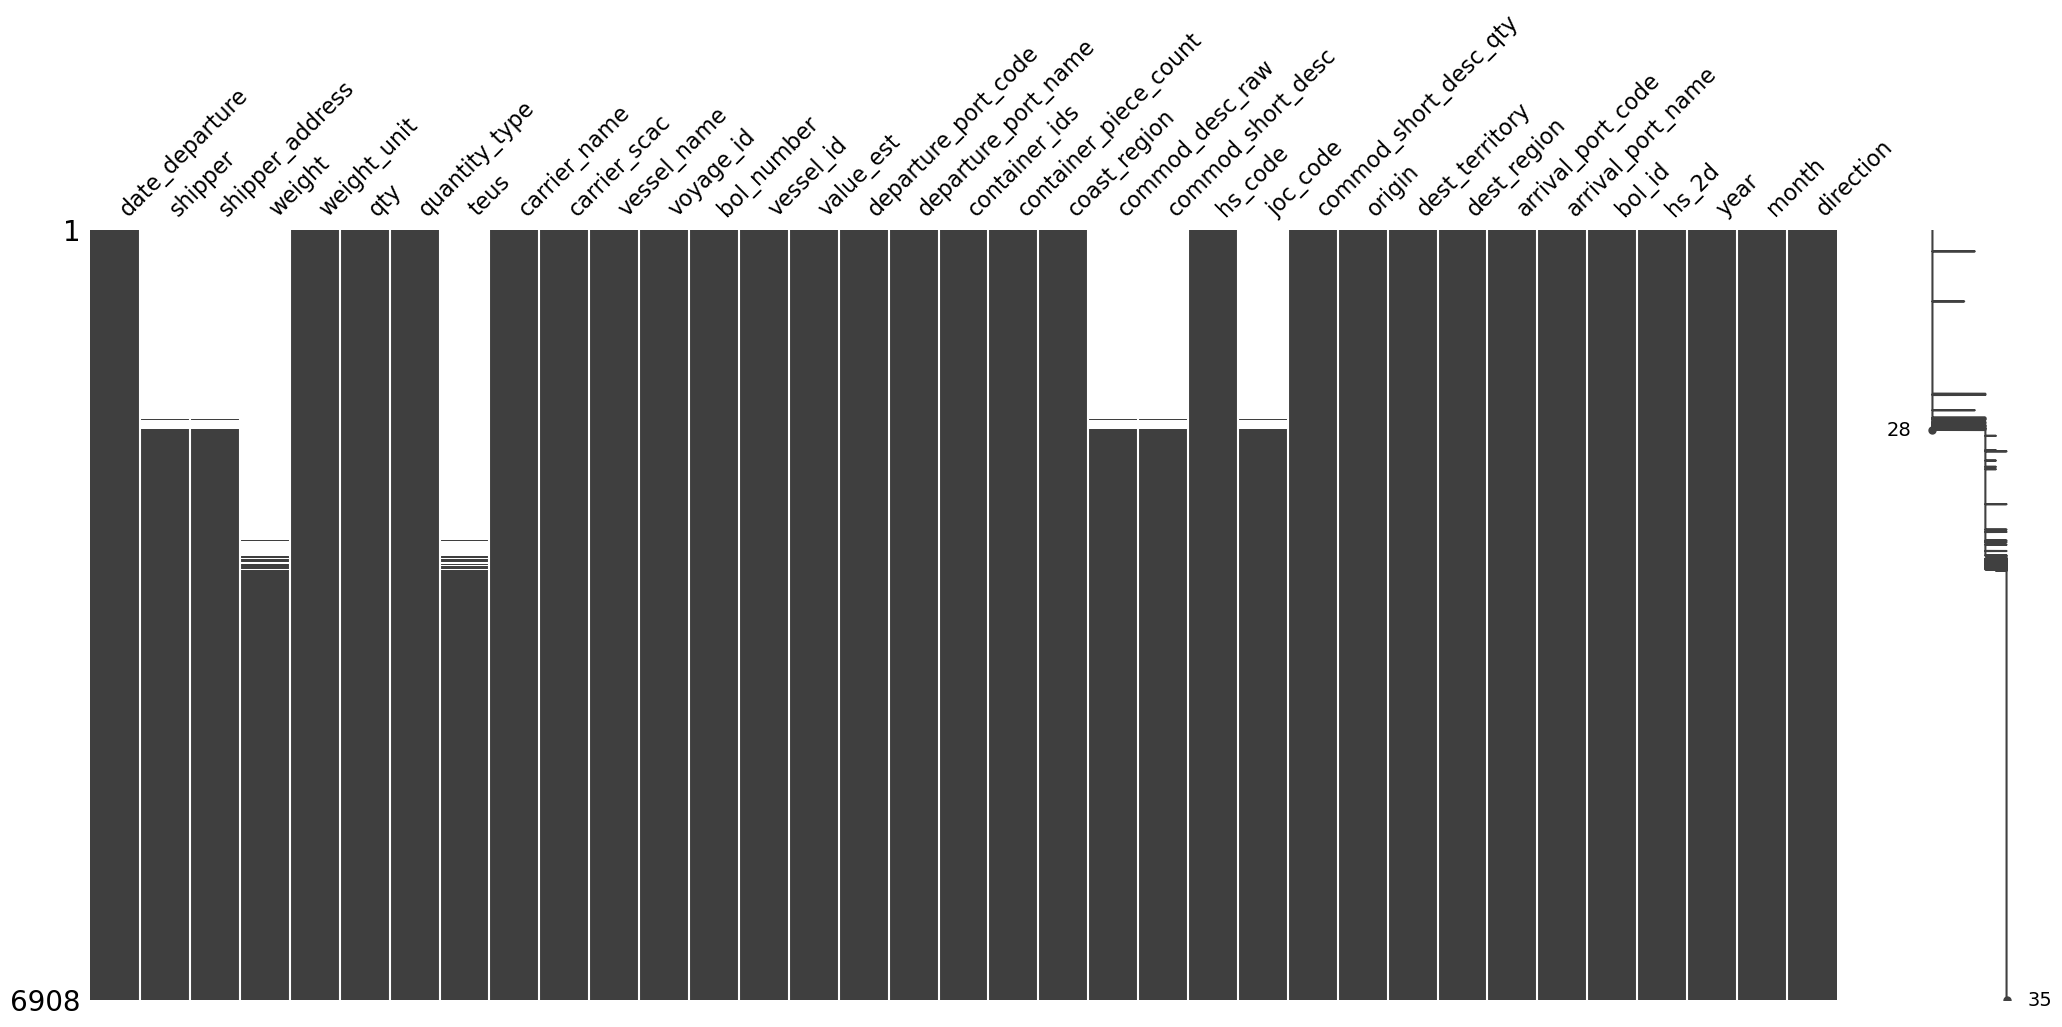

In [3]:
print('Missing Values Matrix for Exports. \nThe vertical axis corresponds to date, with earliest at the top.  \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    exports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_departure').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_departure').sum()
    .sort('date_departure')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

Missing Values Matrix for Imports. 
The vertical axis corresponds to date, with earliest at the top. 
Note the daily aggregation counts the row as non-null if any value that day is non-null.


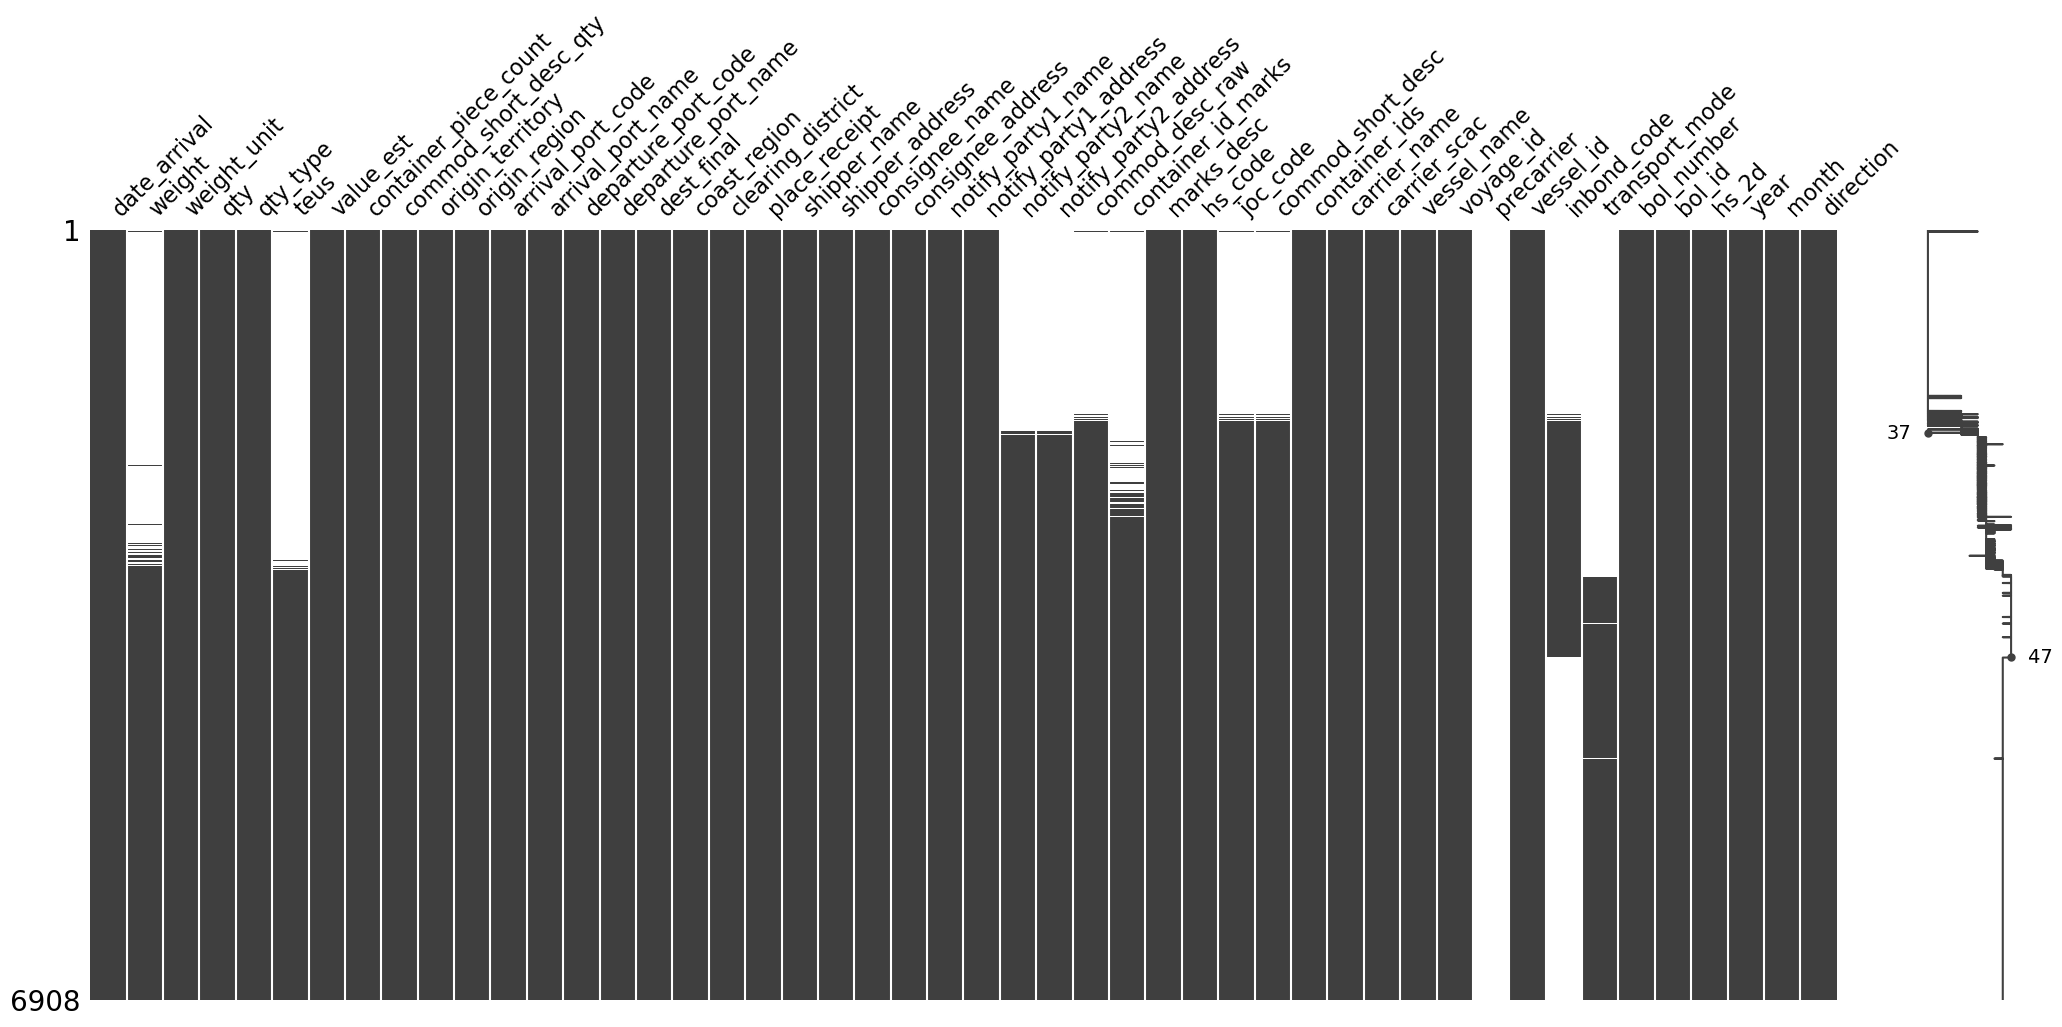

In [4]:
print('Missing Values Matrix for Imports. \nThe vertical axis corresponds to date, with earliest at the top. \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    imports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_arrival').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_arrival').sum()
    .sort('date_arrival')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

### Zero values in TEU and other volume columns

For the time being, we fill the zero (i.e., missing) volume data with the mean from non-zero observations. This step is expected to change as beter metadata is gathered. 

In [5]:
for lf in [imports_lf, exports_lf]:
    lf = (
        lf
        .with_columns([
            pl.col('teus').replace(0,None).fill_null(strategy='mean'),
            pl.col('weight').replace(0,None).fill_null(strategy='mean'),
            pl.col('qty').replace(0,None).fill_null(strategy='mean')
            ])
        )

### Missing Vessel and Voyage IDs

Identifying unique vessels and voyages is critical to studying how long each vessel remains in port, how often carriers utilize alliances (e.g., what proportion of a vessel's cargo is from another carrier), and other quality metrics. The issue is especially concerning given the high proportion (~30% in some time periods) of missing data, as can be seen below.

In [6]:
def nulls_over_time_plotly(data_lf, group_var, time_var, value_var, title=False):
    df = (
        data_lf.select([group_var, time_var, value_var])
        .group_by(group_var, time_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        .cast({group_var:pl.Utf8})
        .sort(time_var, group_var)
    ).collect()
    #plot
    fig = px.line(
        data_frame=df,
        x=time_var, y='null_percent',
        color=group_var,
        title= 'Count of nulls over time by source frame.' if not title else title
    )
    fig.show()

In [7]:
nulls_over_time_plotly(
    data_lf=imports_lf,
    group_var='carrier_scac',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs Names over time.')

In [8]:
nulls_over_time_plotly(
    data_lf=imports_lf.filter(pl.col('carrier_scac')=='AGRD'),
    group_var='carrier_scac',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs Names over time.')

In [9]:
df = imports_lf.select('carrier_scac', 'bol_id', 'hs_2d', 'vessel_name', 'vessel_id', 'month').filter(pl.col('carrier_scac')=='AGRD').collect()
df.describe()

shape: (9, 7)
┌────────────┬──────────────┬───────────┬───────┬─────────────┬────────────┬────────┐
│ describe   ┆ carrier_scac ┆ bol_id    ┆ hs_2d ┆ vessel_name ┆ vessel_id  ┆ month  │
│ ---        ┆ ---          ┆ ---       ┆ ---   ┆ ---         ┆ ---        ┆ ---    │
│ str        ┆ str          ┆ str       ┆ str   ┆ str         ┆ f64        ┆ str    │
╞════════════╪══════════════╪═══════════╪═══════╪═════════════╪════════════╪════════╡
│ count      ┆ 175          ┆ 175       ┆ 175   ┆ 175         ┆ 2.0        ┆ 175    │
│ null_count ┆ 0            ┆ 0         ┆ 0     ┆ 0           ┆ 173.0      ┆ 0      │
│ mean       ┆ null         ┆ null      ┆ null  ┆ null        ┆ 7.738591e6 ┆ null   │
│ std        ┆ null         ┆ null      ┆ null  ┆ null        ┆ 0.0        ┆ null   │
│ min        ┆ null         ┆ AGRD_045  ┆ 00    ┆ CAPE FALCON ┆ 7.738591e6 ┆ 200501 │
│ 25%        ┆ null         ┆ null      ┆ null  ┆ null        ┆ 7.738591e6 ┆ null   │
│ 50%        ┆ null         ┆ null      ┆ null  ┆ null        ┆ 7.738591e6 ┆ null   │
│ 75%        ┆ null         ┆ null      ┆ null  ┆ null        ┆ 7.738591e6 ┆ null   │
│ max        ┆ null         ┆ AGRD_ZZZZ ┆ 90    ┆ OCEAN DAWN  ┆ 7.738591e6 ┆ 200708 │
└────────────┴──────────────┴───────────┴───────┴─────────────┴────────────┴────────┘

In [43]:
def nulls_by_group_plotly(data_lf, group_var, value_var, title=False):
    df = (
        data_lf.select([group_var, value_var])
        .group_by(group_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        .cast({group_var:pl.Utf8})
        .sort('null_percent', descending=True)
    ).collect()
    #plot
    fig = px.bar(
        data_frame=df,
        x=group_var, y='null_percent',
        title= 'Count of nulls by group.' if not title else title
    )
    fig.show()

In [49]:
nulls_by_group_plotly(imports_lf, 'carrier_scac', 'voyage_id')

Assuming each vessel only has one sailing to/from a given port per day, we can fill in missing vessel_id (voyage_id) based on other bols that used the same port the same day on the same voyage (vessel).

In [10]:
def fill_nulls_by_group(data_lf, group_vars, val_var):
    '''Fills null values by group if and only if the val_var for that group contains exactly one non-null unique value.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_vars - iterable - the names of the columns by which groups will be created
        val_var - string - the name of the column in which nulls will be filled
    OUTPUT:
        filled_lf - the resultant lazyframe 
    DEPENDS ON:
        polars - current version written in polars 0.20.1
    '''
    filled_lf = (
        data_lf.with_columns(
            #if the group contains exactly one unique value: 
            pl.when(pl.col(val_var).max().over(group_vars) == pl.col(val_var).min().over(group_vars))
            #fill the group with that value
            .then(pl.col(val_var).max())
            #otherwise do nothing
            .otherwise(pl.col(val_var))
            )
        )
    return filled_lf

In [11]:
for lf in [imports_lf, exports_lf]:
    #fill vessel names and ids based on unique sailings
    lf = fill_nulls_by_group(lf, group_vars=['arrival_port_code', 'date_arrival', 'voyage_id'], val_var='vessel_id')
    lf = fill_nulls_by_group(lf, group_vars=['departure_port_code', 'date_departure', 'voyage_id'], val_var='vessel_id')
    lf = fill_nulls_by_group(lf, group_vars=['arrival_port_code', 'date_arrival', 'voyage_id'], val_var='vessel_name')
    lf = fill_nulls_by_group(lf, group_vars=['departure_port_code', 'date_departure', 'voyage_id'], val_var='vessel_name')

    #fill voyage ids based on similar logic
    lf = fill_nulls_by_group(lf, group_vars=['departure_port_code', 'date_departure', 'vessel_id'], val_var='voyage_id')
    lf = fill_nulls_by_group(lf, group_vars=['arrival_port_code', 'date_arrival', 'vessel_name'], val_var='voyage_id')

    #fill nulls when vessel name-id pairs are available 
    lf = fill_nulls_by_group(lf, 'vessel_name', 'vessel_id')
    lf = fill_nulls_by_group(lf, 'vessel_id', 'vessel_name')

In [12]:
nulls_over_time_plotly(
    data_lf=exports_lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_name',
    title='Proportion of Missing Vessel Names over time (Exports).'
)

## Export Clean data to parquet


In [13]:
#piers_lf.sink_parquet('data/piers_clean.parquet') -- NOTE the above queries are apparently not supported for sinking at this time. 